# Data Analysis

In [42]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm, genextreme
import numpy as np
from datetime import datetime
from data import get_data, extract_date_data
from utils import get_path, load_model_data, month, day_of_week, precip_type
plt.style.use('ggplot')

## Feature selection

We start by loading in the weather features and choosing a (roughly) independent subset of these to use for training our model.

In [3]:
weather_df = pd.read_csv(get_path('data') / 'weather_data.tsv', sep = '\t')
weather_df['precip_type'] = weather_df['precip_type'].map(precip_type)
weather_df.head()

,date,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity
0,2018-02-03,0.1336,0.0190,1,3.27,3.25,10.24,4.03,0.18,2.84,1.58,2.84,-3.10,0.83
1,2018-02-04,0.0129,0.0005,1,7.07,7.05,11.88,7.28,-3.10,-0.07,-1.50,-0.20,-3.27,0.76
2,2018-02-05,0.0000,0.0000,0,7.72,7.74,9.97,7.84,-4.58,-1.02,-2.71,-1.02,-5.55,0.74
3,2018-02-06,0.0000,0.0000,0,5.84,5.86,6.98,5.88,-5.55,-2.78,-4.15,-2.78,-5.11,0.74
4,2018-02-07,0.0000,0.0000,0,3.62,3.65,5.26,3.74,-5.11,-0.01,-2.72,-0.01,-2.83,0.68


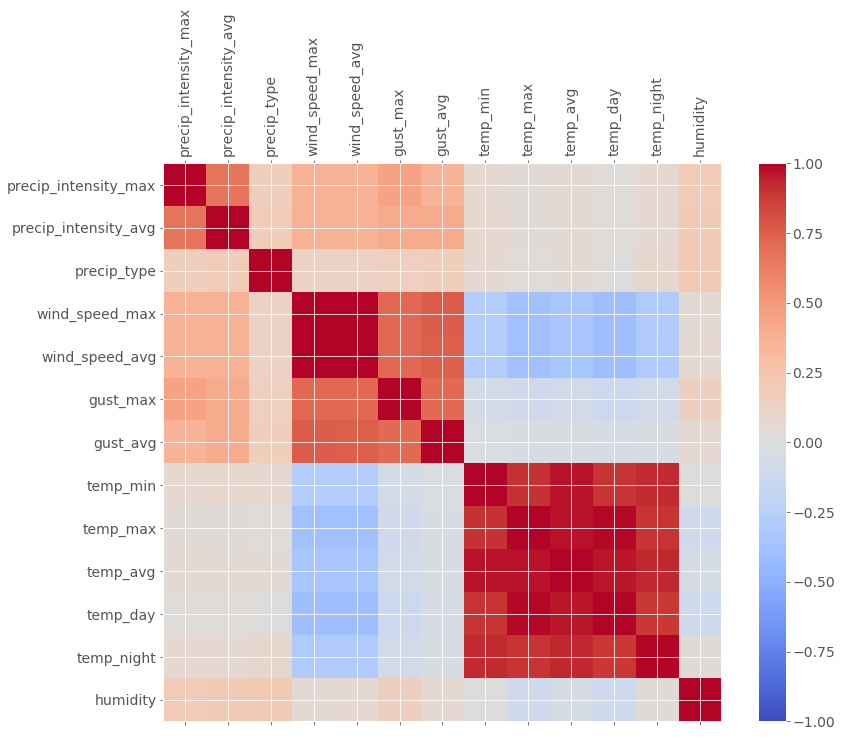

In [4]:
feat_df = weather_df.copy()[[col for col in list(weather_df.columns) if col not in ['date']]]
f = plt.figure(figsize = (13, 10))
plt.matshow(feat_df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(feat_df.shape[1]), feat_df.columns, fontsize=14, rotation=90)
plt.yticks(range(feat_df.shape[1]), feat_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

As we can see on the above heatmap, our weather features are highly dependent, so we *do* need to trim these down a bit.

We see that the majority of the dependencies cluster in three groups: precipitation, wind speed / gusts, and temperature. We therefore start by only including the average values of these three groups, as we hypothesise that these averages will be more reliable when we fetch forecasts for our predictions.

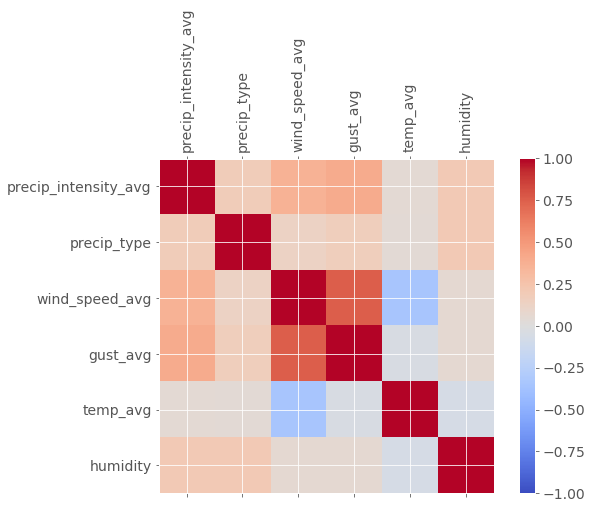

In [5]:
features = ['precip_intensity_avg', 'precip_type', 'wind_speed_avg', 'gust_avg', 'temp_avg', 'humidity']
trimmed_feat_df = weather_df.copy()[features]
f = plt.figure(figsize = (9, 6))
plt.matshow(trimmed_feat_df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(trimmed_feat_df.shape[1]), trimmed_feat_df.columns, fontsize=14, rotation=90)
plt.yticks(range(trimmed_feat_df.shape[1]), trimmed_feat_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

The major dependency remaining is between wind speed average and gust average, so we remove the gust average.

This is again because we hypothesise that wind speeds are easier to forecast.

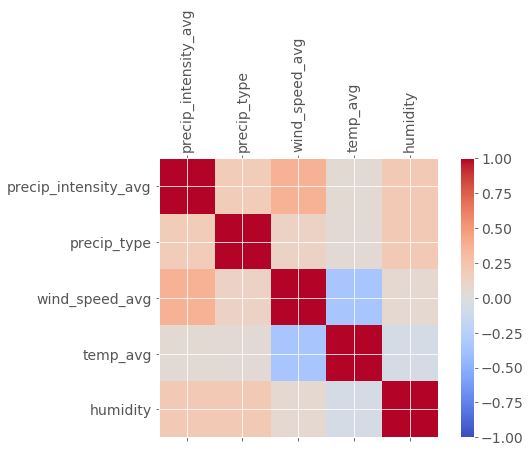

In [6]:
features = ['precip_intensity_avg', 'precip_type', 'wind_speed_avg', 'temp_avg', 'humidity']
final_feat_df = weather_df.copy()[features]
f = plt.figure(figsize = (8, 5))
plt.matshow(final_feat_df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(final_feat_df.shape[1]), final_feat_df.columns, fontsize=14, rotation=90)
plt.yticks(range(final_feat_df.shape[1]), final_feat_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

This looks good! We'll also be using some date-related features: `month`, `day_of_month` and `day_of_week`.

Let's load in our training dataset with all these features.

In [7]:
X, y = get_data(include_date = True)
df = X.copy()
X.drop(columns = ['date'], inplace = True)
df['total'] = y.copy()
df.head()

,date,month,day_of_month,day_of_week,precip_intensity_avg,precip_type,wind_speed_avg,temp_avg,humidity,total
0,2018-02-03,2,3,6,0.019,1,3.25,1.58,0.83,45
1,2018-02-24,2,24,6,0.000,0,8.92,-5.33,0.60,34
2,2018-03-03,3,3,6,0.014,2,5.08,-3.55,0.86,45
3,2018-02-05,2,5,1,0.000,0,7.74,-2.71,0.74,47
4,2018-03-05,3,5,1,0.000,0,4.76,2.27,0.87,42


## Analysis of target labels

Now that we've chosen our features, let's have a look at what we're trying to predict.

Here's a plot of the reported total demand for a Bristol Soup Run Trust (BSRT) over time.

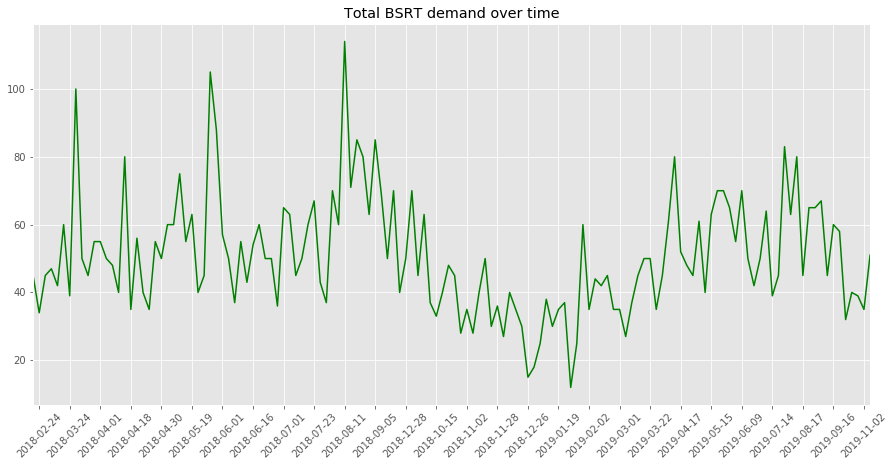

In [8]:
xticks = list(range(1, len(df.index), 5))
ax = df.total.plot(figsize = (15, 7), title = 'Total BSRT demand over time', 
                   rot = 45, xticks = xticks, color = 'g')
ax.set_xticklabels(df.date[xticks])
plt.show()

We also see that these values approximately follow a normal distribution, as can be seen on the following histogram.

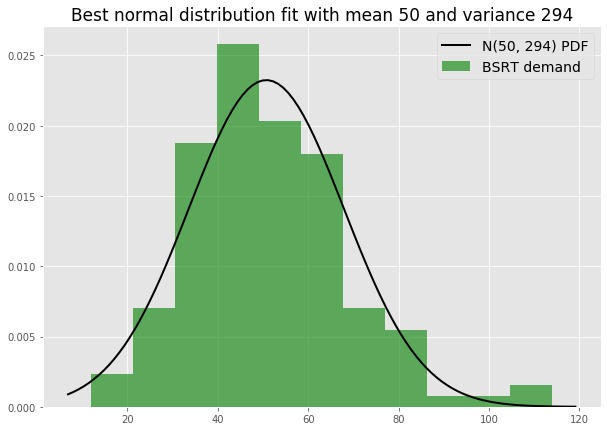

In [9]:
plt.figure(figsize = (10,7))

# Plot the histogram.
plt.hist(df['total'], bins=11, density=True, alpha=0.6, color='g', label = 'BSRT demand')

# Plot the PDF.
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
mu, sigma = norm.fit(df['total'])
pdf = norm.pdf(xs, mu, sigma)
plt.plot(xs, pdf, color = 'k', linewidth = 2, label = f'N({int(mu)}, {int(sigma ** 2)}) PDF')

plt.title(f'Best normal distribution fit with mean {int(mu)} and variance {int(sigma ** 2)}', fontsize = 17)
plt.legend(fontsize = 14)
plt.show()

We won't be needing this here, but out of interest here are the bootstrap distributions of various quantile values of our data.

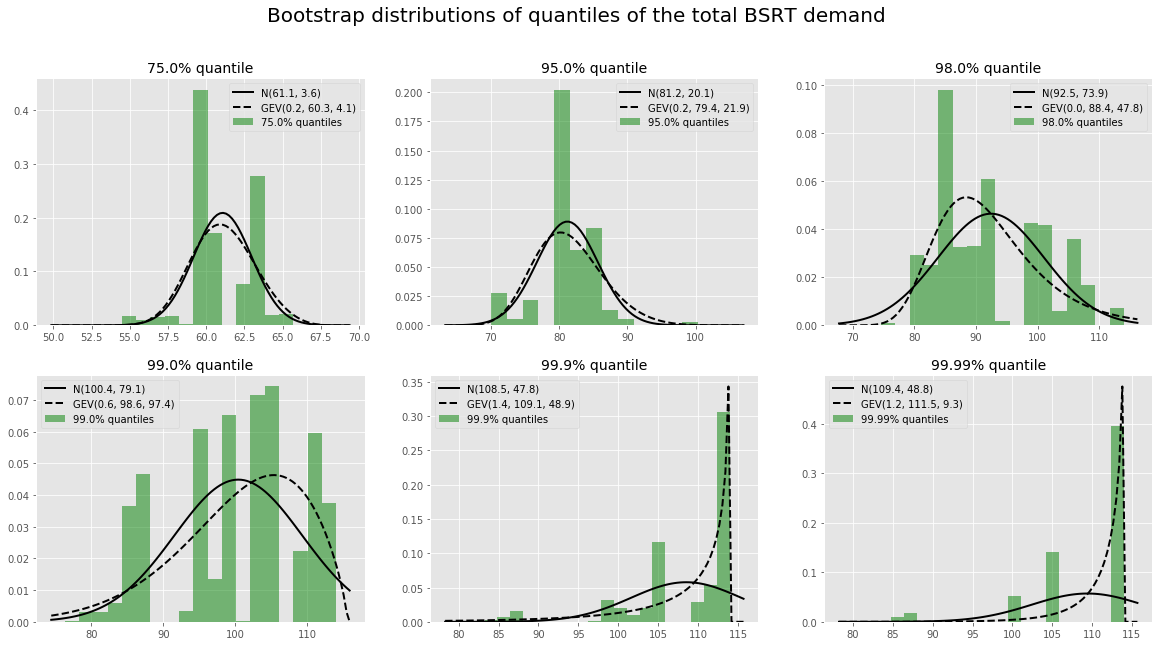

In [59]:
nbootstraps = 10000

fig, ax = plt.subplots(2, 3, figsize = (20, 10))

alphas = np.array([[75, 95, 98], [99, 99.9, 99.99]])
for i in range(alphas.shape[0]):
    for j in range(alphas.shape[1]):
        quantiles = np.empty(nbootstraps)
        for b in range(nbootstraps):
            sample = np.random.choice(df.total, size = len(df.total), replace = True)
            #sample = np.random.uniform(size = 500)
            quantiles[b] = np.percentile(sample, alphas[i, j])

        # Plot the histogram. See the possible values that `bins` can take at
        # docs.scipy.org/doc/numpy/reference/generated/numpy.histogram_bin_edges.html
        ax[i,j].hist(quantiles, bins = 'doane', density = True, alpha = 0.5, color = 'g', 
                 label = f'{alphas[i, j]}% quantiles')

        # Plot the PDFs
        xmin, xmax = ax[i, j].get_xlim()
        xs = np.linspace(xmin, xmax, 100)
        
        mu, sigma = norm.fit(quantiles)
        pdf = norm.pdf(xs, mu, sigma)
        ax[i,j].plot(xs, pdf, color = 'k', linewidth = 2, 
                     label = f'N({round(mu, 1)}, {round(sigma ** 2, 1)})')
        
        shape, mu, sigma = gev.fit(quantiles)
        pdf = genextreme.pdf(xs, shape, mu, sigma)
        ax[i,j].plot(xs, pdf, color = 'k', linestyle = 'dashed', linewidth = 2, 
                     label = f'GEV({round(shape, 1)}, {round(mu, 1)}, {round(sigma ** 2, 1)})')
        
        ax[i,j].set_title(f'{alphas[i, j]}% quantile', fontsize = 14)
        ax[i,j].legend(fontsize = 10)
        
fig.suptitle('Bootstrap distributions of quantiles of the total BSRT demand', fontsize = 20)
#fig.suptitle('Bootstrap distributions of the quantiles of the uniform distribution', fontsize = 20)
plt.show()

## Model selection

We fitted a wide variety of models to the data, and we found that forest-based estimators performed the best in terms of mean absolute error (MAE). Further, we refined this by choosing a forest of `ExtraTrees`, which also performs the splittings in the individual trees at random, reducing variance.

We performed a Bayesian hyperparameter search for 150 iterations over all the parameters in the forest, and found that the only parameter that resulted in better performance over the default values were the number of trees, which we increased from 100 to 3000.

## Prediction intervals

We also wanted to have an idea of the uncertainty coupled with the predictions. We therefore wanted to estimate the variance of the predictions, to approximate both the sample noise and the noise within the trees themselves. A common way of doing this is by trainin the same forest on *bootstrapped samples*, which are datasets that are sampled from our original dataset with replacement, simulating "random datasets".

The problem with this is inference time: if we're using, say, 1000 bootstrapped datasets, then we need to apply each of our 3000 trees a thousand times every time we want to make a prediction.

A solution to this problem was found in the 2014 paper `Confidence intervals for random forests: The jackknife and the infinitesimal jackknife` by Wager, Hastie and Efron. They found a way to estimate the variance by *only using the trees once*.

For this to work we need to have trained our trees on bootstrapped samples, which reduced the performance of the model by a tiny bit (~1 MAE), but we are willing to sacrifice this small amount of performance to reduce the prediction time by a factor of 1000. We've implemented their method into the class `pExtraTreesRegressor`.

With their estimate of variance, we can then proceed to compute the standard error of the predictions. We're fortunate that our target values are normally distributed, which allows us to compute the standard prediction error as follows:

$$ \textsf{SE} = \textsf{Var}_b[\mathcal T_b(x)]^{1/2}\sqrt{1 + \tfrac{1}{B}}, $$

where $x$ is a new sample, $\mathcal T_b(x)$ is the prediction of the $b$'th tree, and $B$ is the amount of trees in the forest. We can therefore compute our $\alpha$ prediction intervals as

$$ \text{Prediction interval} = \mathbb{E}_b[\mathcal T_b(x)] \pm T_\alpha^{n-1}\textsf{SE}, $$

where $n$ is the number of training samples, and $T_\alpha^{n-1}$ is the $\tfrac{1 + \alpha}{2}$ percentile of the t-distribution with $n-1$ degrees of freedom.

As an example, if $\alpha = 95\%$ and we have 138 training samples (as is in fact the case) then $T_\alpha^{n-1}\sim 1.98$. In general, as we have more training samples then this will converge to the familiar $1.96$ as the t-distribution converges to the normal distribution.

These are all implemented in the `predict` method of the `pExtraTreesRegressor` class, just set `return_intervals = True`.

## Visualising model performance

We now visualise the performance of the choice of model. We do this by restricting ourselves to a shorter period, and thereby also restricting the number of training samples, and then attempt to predict the following period. We choose here to show the 50%, 80%, 95% and 99% prediction intervals.

In [ ]:
alphas = [0.5, .8, .95, .99]
opacities = np.linspace(0.05, 0.4, len(alphas))

In [ ]:
def earlier_than(date1: str, date2: str):
    from datetime import datetime
    date1, date2 = datetime.strptime(date1, '%Y-%m-%d'), datetime.strptime(date2, '%Y-%m-%d')
    return date1 < date2

In [ ]:
def viz_model(cutoff_date = '2019-09-01'):
    train_idxs = [idx for idx, date in zip(df.index, df.date) if earlier_than(date, cutoff_date)]
    
    X_train, X_val = X.iloc[train_idxs, :], X.iloc[list(set(df.index) - set(train_idxs)), :]
    y_train, y_val = y[train_idxs], y[list(set(df.index) - set(train_idxs))]
    idxs = sorted(X_val.index)
    
    fig, ax = plt.subplots(figsize = (15, 7))
    plt.plot(df.date[idxs], df.total[idxs], label = 'True values', color = 'grey')
    
    model = load_model_data()['model'].fit(X_train, y_train)
    for idx, alpha in enumerate(alphas):
        preds, cis = model.predict(X_val, return_cis = True, alpha = alpha)
        plt.fill_between(df.date[idxs], cis[:, 0], cis[:, 1], 
                     figure = fig, color = 'purple', alpha = opacities[-(idx + 1)], 
                         label = f'{round(100 * alpha, 1)}% prediction interval')
    plt.legend(fontsize = 13)
    plt.xticks(rotation = 60)
    plt.title(f'Predictions - {type(model).__name__}', fontsize = 18)  
    
    plt.show()

In [ ]:
viz_model(cutoff_date = '2019-09-01')

As we can see, the model is not too bad, as the predictions actually end up within the prediction intervals most of the time.

Note also that the actual model is better than this, as it's trained on more data.

## Using the model to impute data

We can also use the (fully trained) model to impute all the missing values in our data set.

We have weather data for all the dates in `weather_df`, so we just need to extract the date features and merge them.

In [ ]:
dates = weather_df['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
date_df = extract_date_data(dates)
date_df.head()

In [ ]:
feat_df = pd.concat([date_df, weather_df[['date'] + features]], axis = 1)
feat_df.head()

In [ ]:
feat_df['month'] = feat_df['month'].map(month)
feat_df['day_of_week'] = feat_df['day_of_week'].map(day_of_week)
feat_df.head()

We next load our model and perform all the ~600 predictions for the missing values.

In [ ]:
model = load_model_data()['model']
model

In [ ]:
pred_df = feat_df.copy()
for alpha in alphas:
    preds, cis = model.predict(feat_df.drop(columns = ['date']), return_cis = True, alpha = alpha)
    pred_df['prediction'] = preds
    pred_df[round(100 * (1 - alpha) / 2, 1)] = cis[:, 0]
    pred_df[round(100 * ((1 - alpha) / 2 + alpha), 1)] = cis[:, 1]
pred_df.head()

Using these predictions, let's predict the imputed values.

In [ ]:
fig, ax = plt.subplots(figsize = (40, 13))

for idx, alpha in enumerate(alphas):
    plt.fill_between(pred_df.date, 
                     pred_df[round(100 * (1 - alpha) / 2, 1)], 
                     pred_df[round(100 * ((1 - alpha) / 2 + alpha), 1)],
                     figure = fig, 
                     color = 'purple', 
                     alpha = opacities[-(idx + 1)],
                     label = f'{int(round(alpha * 100))}% prediction interval'
                     )
plt.scatter(df.date, df.total, color = 'green', label = 'True values')
plt.xticks(range(1, len(pred_df.index), 25), 
           pred_df.date[list(range(1, len(pred_df.index), 25))], 
           rotation = 45)
plt.legend(fontsize = 17)
plt.title(f'Imputing total demand with {type(model).__name__}', fontsize = 30)
plt.show()

In [ ]:
proj_preds = pred_df.copy()[pred_df.date.isin(df.date)]
below_upper = df.total.values <= proj_preds[97.5].values
above_lower = df.total.values >= proj_preds[2.5].values
accuracy = sum(below_upper & above_lower) / len(df)

err_df = proj_preds.copy()
err_df['total'] = df.total.values
above_upper = err_df[~below_upper]
above_err = (above_upper.total - above_upper[97.5]).mean()
below_lower = err_df[~above_lower]
below_err = (below_lower[2.5] - below_lower.total).mean()
off_value = round((above_err + below_err) / 2, 2)

interval_size = (proj_preds[97.5].values - proj_preds[2.5].values).mean()

print(f'{round(accuracy * 100, 2)}% of the demand was within the 95% prediction interval.')
print(f'The values outside the interval were on average {off_value} off.')
print(f'The average length of the 95% prediction interval is {round(interval_size, 2)}.')

We see that the intervals capture most of the values, which should also be the case as those are the values that we trained the model on!